In [9]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score

In [2]:
# Custom Dataset class
class TORCSDataset(Dataset):
    def __init__(self, csv_file, sensor_cols, continuous_cols, discrete_cols):
        self.data = pd.read_csv(csv_file)
        self.sensor_cols = [col for col in self.data.columns if col in sensor_cols]
        # self.sensor_cols = sensor_cols
        self.continuous_cols = [col for col in self.data.columns if col in continuous_cols]
        # self.continuous_cols = continuous_cols
        self.discrete_cols = [col for col in self.data.columns if col in discrete_cols]
        # self.discrete_cols = discrete_cols
        self.features = torch.tensor(self.data[self.sensor_cols].values, dtype=torch.float32)
        self.continuous_labels = torch.tensor(self.data[self.continuous_cols].values, dtype=torch.float32)
        self.gear_labels = torch.tensor(self.data['Gear'].values, dtype=torch.long)
        self.clutch_labels = torch.tensor(self.data['Clutch'].values, dtype=torch.long)
        # Adjust Gear/Clutch to zero-based indexing
        # self.gear_labels = self.gear_labels - self.gear_labels.min()
                # Remap Gear labels: [-1, 1, 2, 3] -> [0, 1, 2, 3]
        gear_mapping = {-1: 0, 1: 1, 2: 2, 3: 3}
        self.gear_labels = torch.tensor([gear_mapping[val] for val in self.data['Gear']], dtype=torch.long)

                # Remap Clutch labels: [0.0, 0.5] -> [0, 1]
        clutch_mapping = {0.0: 0, 0.5: 1}
        self.clutch_labels = torch.tensor([clutch_mapping[val] for val in self.data['Clutch']], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (self.features[idx], self.continuous_labels[idx], 
                self.gear_labels[idx], self.clutch_labels[idx])

In [ ]:
# Neural Network Model
class TORCSNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_gear_classes, num_clutch_classes):
        super(TORCSNet, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),  # Third hidden layer
            nn.ReLU()
            nn.Dropout(0.3)
        )
        self.continuous_head = nn.Linear(hidden_size, 3)
        self.gear_head = nn.Linear(hidden_size, num_gear_classes)
        self.clutch_head = nn.Linear(hidden_size, num_clutch_classes)

    def forward(self, x):
        shared_features = self.shared(x)
        continuous_out = self.continuous_head(shared_features)
        accel_brake = torch.sigmoid(continuous_out[:, :2])  # [0, 1]
        steering = torch.tanh(continuous_out[:, 2])         # [-1, 1]
        continuous_out = torch.cat([accel_brake, steering.unsqueeze(1)], dim=1)
        gear_out = self.gear_head(shared_features)
        clutch_out = self.clutch_head(shared_features)
        return continuous_out, gear_out, clutch_out

In [4]:
# Training function
def train_model(model, train_loader, val_loader, num_epochs, device):
    criterion_cont = nn.MSELoss()
    # Class weights for Gear and Clutch
    gear_class_weights = torch.tensor([1.0 / 469, 1.0 / 90333, 1.0 / 61333, 1.0 / 79053], dtype=torch.float32).to(device)
    clutch_class_weights = torch.tensor([1.0 / 229502, 1.0 / 1686], dtype=torch.float32).to(device)
    criterion_gear = nn.CrossEntropyLoss(weight=gear_class_weights)
    criterion_clutch = nn.CrossEntropyLoss(weight=clutch_class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_cont_losses = []
    train_gear_losses = []
    train_clutch_losses = []
    val_gear_accs = []
    val_clutch_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_cont_loss = 0.0
        train_gear_loss = 0.0
        train_clutch_loss = 0.0
        for features, cont_labels, gear_labels, clutch_labels in train_loader:
            features = features.to(device)
            cont_labels = cont_labels.to(device)
            gear_labels = gear_labels.to(device)
            clutch_labels = clutch_labels.to(device)
            
            optimizer.zero_grad()
            cont_out, gear_out, clutch_out = model(features)
            
            loss_cont = criterion_cont(cont_out, cont_labels)
            loss_gear = criterion_gear(gear_out, gear_labels)
            loss_clutch = criterion_clutch(clutch_out, clutch_labels)
            loss = loss_cont + loss_gear + loss_clutch  # Equal weighting
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * features.size(0)
            train_cont_loss += loss_cont.item() * features.size(0)
            train_gear_loss += loss_gear.item() * features.size(0)
            train_clutch_loss += loss_clutch.item() * features.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_cont_loss /= len(train_loader.dataset)
        train_gear_loss /= len(train_loader.dataset)
        train_clutch_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        train_cont_losses.append(train_cont_loss)
        train_gear_losses.append(train_gear_loss)
        train_clutch_losses.append(train_clutch_loss)
        
        model.eval()
        val_loss = 0.0
        gear_correct = 0
        clutch_correct = 0
        total = 0
        with torch.no_grad():
            for features, cont_labels, gear_labels, clutch_labels in val_loader:
                features = features.to(device)
                cont_labels = cont_labels.to(device)
                gear_labels = gear_labels.to(device)
                clutch_labels = clutch_labels.to(device)
                
                cont_out, gear_out, clutch_out = model(features)
                loss_cont = criterion_cont(cont_out, cont_labels)
                loss_gear = criterion_gear(gear_out, gear_labels)
                loss_clutch = criterion_clutch(clutch_out, clutch_labels)
                loss = loss_cont + loss_gear + loss_clutch
                val_loss += loss.item() * features.size(0)
                
                _, gear_pred = torch.max(gear_out, 1)
                _, clutch_pred = torch.max(clutch_out, 1)
                gear_correct += (gear_pred == gear_labels).sum().item()
                clutch_correct += (clutch_pred == clutch_labels).sum().item()
                total += gear_labels.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        gear_acc = gear_correct / total
        clutch_acc = clutch_correct / total
        val_gear_accs.append(gear_acc)
        val_clutch_accs.append(clutch_acc)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, Train Cont Loss: {train_cont_loss:.4f}, '
              f'Train Gear Loss: {train_gear_loss:.4f}, Train Clutch Loss: {train_clutch_loss:.4f}, '
              f'Gear Acc: {gear_acc:.4f}, Clutch Acc: {clutch_acc:.4f}')
        
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
    
    # Plot losses and accuracies
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Total Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Val Total Loss')
    plt.plot(range(1, num_epochs+1), train_cont_losses, label='Train Cont Loss')
    plt.plot(range(1, num_epochs+1), train_gear_losses, label='Train Gear Loss')
    plt.plot(range(1, num_epochs+1), train_clutch_losses, label='Train Clutch Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.plot(range(1, num_epochs+1), val_gear_accs, label='Gear Acc')
    plt.plot(range(1, num_epochs+1), val_clutch_accs, label='Clutch Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Gear and Clutch Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('loss_plot.png')
    plt.show()
    
    return train_losses, val_losses


In [ ]:
# def evaluate_model(model, dataloader, device):
#     model.eval()
    
#     all_preds_reg = []
#     all_targets_reg = []

#     all_preds_gear = []
#     all_targets_gear = []

#     all_preds_clutch = []
#     all_targets_clutch = []

#     with torch.no_grad():
#         for features, targets in dataloader:
#             features = features.to(device)
#             acceleration_true = targets['Acceleration'].to(device)
#             braking_true = targets['Braking'].to(device)
#             steering_true = targets['Steering'].to(device)
#             gear_true = targets['Gear'].to(device)
#             clutch_true = targets['Clutch'].to(device)

#             acceleration_pred, braking_pred, steering_pred, gear_logits, clutch_logits = model(features)

#             # Store regression values
#             all_preds_reg.append(torch.stack([acceleration_pred, braking_pred, steering_pred], dim=1).cpu().numpy())
#             all_targets_reg.append(torch.stack([acceleration_true, braking_true, steering_true], dim=1).cpu().numpy())

#             # Store classification predictions
#             all_preds_gear.extend(torch.argmax(gear_logits, dim=1).cpu().numpy())
#             all_targets_gear.extend(gear_true.cpu().numpy())

#             all_preds_clutch.extend(torch.argmax(clutch_logits, dim=1).cpu().numpy())
#             all_targets_clutch.extend(clutch_true.cpu().numpy())

#     # Compute Regression MSE
#     y_true_reg = np.vstack(all_targets_reg)
#     y_pred_reg = np.vstack(all_preds_reg)

#     mse_acceleration = mean_squared_error(y_true_reg[:, 0], y_pred_reg[:, 0])
#     mse_braking = mean_squared_error(y_true_reg[:, 1], y_pred_reg[:, 1])
#     mse_steering = mean_squared_error(y_true_reg[:, 2], y_pred_reg[:, 2])

#     # Classification Accuracy
#     gear_acc = accuracy_score(all_targets_gear, all_preds_gear)
#     clutch_acc = accuracy_score(all_targets_clutch, all_preds_clutch)

#     print(f"\n=== Evaluation Results ===")
#     print(f"Acceleration MSE: {mse_acceleration:.4f}")
#     print(f"Braking MSE: {mse_braking:.4f}")
#     print(f"Steering MSE: {mse_steering:.4f}")
#     print(f"Gear Accuracy: {gear_acc * 100:.2f}%")
#     print(f"Clutch Accuracy: {clutch_acc * 100:.2f}%")

In [5]:
import pandas as pd

# Check train_data.csv
train_data = pd.read_csv('../data_generation/data/dirt-2/train_data.csv')
print("Columns in train_data.csv:")
print(train_data.columns.tolist())
print("Number of columns:", len(train_data.columns))

# Check val_data.csv
val_data = pd.read_csv('../data_generation/data/dirt-2/val_data.csv')
print("\nColumns in val_data.csv:")
print(val_data.columns.tolist())
print("Number of columns:", len(val_data.columns))

Columns in train_data.csv:
['Angle', ' CurrentLapTime', ' Damage', ' DistanceFromStart', ' DistanceCovered', ' FuelLevel', ' LastLapTime', ' Opponent_1', 'RacePosition', ' RPM', ' SpeedX', ' SpeedY', ' SpeedZ', ' Track_1', 'Track_2', 'Track_3', 'Track_4', 'Track_5', 'Track_6', 'Track_7', 'Track_8', 'Track_9', 'Track_10', 'Track_11', 'Track_12', 'Track_13', 'Track_14', 'Track_15', 'Track_16', 'Track_17', 'Track_18', 'Track_19', 'TrackPosition', ' WheelSpinVelocity_1', 'WheelSpinVelocity_2', 'WheelSpinVelocity_3', 'WheelSpinVelocity_4', 'Z', ' Acceleration', 'Braking', 'Clutch', 'Gear', 'Steering']
Number of columns: 43

Columns in val_data.csv:
['Angle', ' CurrentLapTime', ' Damage', ' DistanceFromStart', ' DistanceCovered', ' FuelLevel', ' LastLapTime', ' Opponent_1', 'RacePosition', ' RPM', ' SpeedX', ' SpeedY', ' SpeedZ', ' Track_1', 'Track_2', 'Track_3', 'Track_4', 'Track_5', 'Track_6', 'Track_7', 'Track_8', 'Track_9', 'Track_10', 'Track_11', 'Track_12', 'Track_13', 'Track_14', 'Tra

In [6]:
# Define columns
sensor_cols = ['Angle', ' CurrentLapTime', ' Damage', ' DistanceFromStart', ' DistanceCovered', 
                ' FuelLevel', ' LastLapTime', 'RacePosition', ' RPM', 
               ' SpeedX', ' SpeedY', ' SpeedZ', ' Track_1', 'Track_2', 'Track_3', 
               'Track_4', 'Track_5', 'Track_6', 'Track_7', 'Track_8', 'Track_9', 
               'Track_10', 'Track_11', 'Track_12', 'Track_13', 'Track_14', 'Track_15', 
               'Track_16', 'Track_17', 'Track_18', 'Track_19', 'TrackPosition', 
                ' WheelSpinVelocity_1', 'WheelSpinVelocity_2', 'WheelSpinVelocity_3', 
               'WheelSpinVelocity_4', 'Z']
continuous_cols = [' Acceleration', 'Braking', 'Steering']
discrete_cols = ['Gear', 'Clutch']
    
# Load datasets
train_dataset = TORCSDataset('../data_generation/data/dirt-2/train_data.csv', sensor_cols, continuous_cols, discrete_cols)
val_dataset = TORCSDataset('../data_generation/data/dirt-2/val_data.csv', sensor_cols, continuous_cols, discrete_cols)
    
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


In [45]:
print(len(sensor_cols))
# print(continuous_cols)

print(len(train_dataset.sensor_cols))

train_dataset.sensor_cols
# val_dataset.sensor_cols

37
37


['Angle',
 ' CurrentLapTime',
 ' Damage',
 ' DistanceFromStart',
 ' DistanceCovered',
 ' FuelLevel',
 ' LastLapTime',
 'RacePosition',
 ' RPM',
 ' SpeedX',
 ' SpeedY',
 ' SpeedZ',
 ' Track_1',
 'Track_2',
 'Track_3',
 'Track_4',
 'Track_5',
 'Track_6',
 'Track_7',
 'Track_8',
 'Track_9',
 'Track_10',
 'Track_11',
 'Track_12',
 'Track_13',
 'Track_14',
 'Track_15',
 'Track_16',
 'Track_17',
 'Track_18',
 'Track_19',
 'TrackPosition',
 ' WheelSpinVelocity_1',
 'WheelSpinVelocity_2',
 'WheelSpinVelocity_3',
 'WheelSpinVelocity_4',
 'Z']

In [7]:
    # Model parameters
input_size = len(sensor_cols)
print(input_size)
hidden_size = 128
num_gear_classes = len(train_dataset.data['Gear'].unique())
num_clutch_classes = len(train_dataset.data['Clutch'].unique())
    
# Initialize model
device = torch.device('cpu')
model = TORCSNet(input_size, hidden_size, num_gear_classes, num_clutch_classes).to(device)

37


Epoch 1/50, Train Loss: 1.1197, Val Loss: 0.7944, Train Cont Loss: 0.6876, Train Gear Loss: 0.1606, Train Clutch Loss: 0.2715, Gear Acc: 0.9833, Clutch Acc: 0.9550
Epoch 2/50, Train Loss: 0.7894, Val Loss: 0.7103, Train Cont Loss: 0.6023, Train Gear Loss: 0.0481, Train Clutch Loss: 0.1390, Gear Acc: 0.9881, Clutch Acc: 0.9673
Epoch 3/50, Train Loss: 0.6956, Val Loss: 0.6593, Train Cont Loss: 0.5639, Train Gear Loss: 0.0354, Train Clutch Loss: 0.0964, Gear Acc: 0.9909, Clutch Acc: 0.9697
Epoch 4/50, Train Loss: 0.6762, Val Loss: 0.6957, Train Cont Loss: 0.5440, Train Gear Loss: 0.0362, Train Clutch Loss: 0.0960, Gear Acc: 0.9772, Clutch Acc: 0.9803
Epoch 5/50, Train Loss: 0.6392, Val Loss: 0.6345, Train Cont Loss: 0.5293, Train Gear Loss: 0.0286, Train Clutch Loss: 0.0812, Gear Acc: 0.9920, Clutch Acc: 0.9594
Epoch 6/50, Train Loss: 0.6327, Val Loss: 0.6416, Train Cont Loss: 0.5229, Train Gear Loss: 0.0272, Train Clutch Loss: 0.0827, Gear Acc: 0.9927, Clutch Acc: 0.9876
Epoch 7/50, Trai

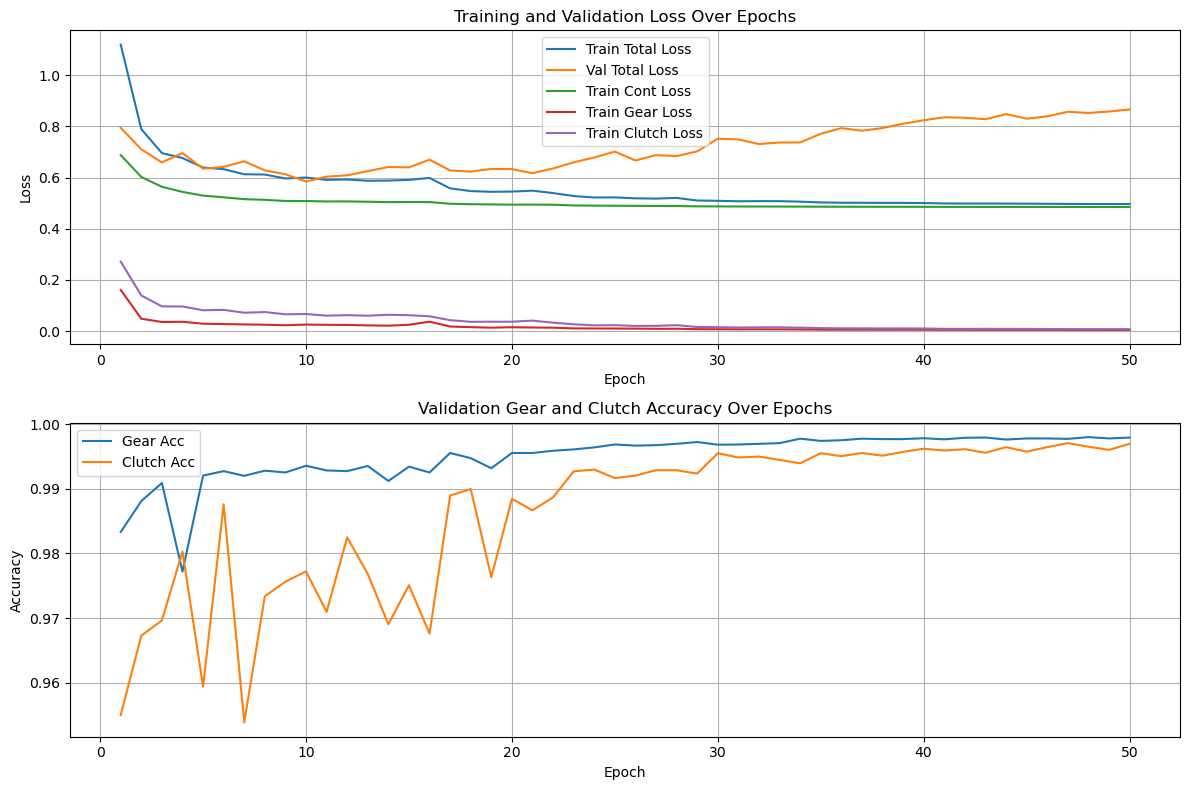

Training complete. Best model saved as 'best_model.pt'. Loss plot saved as 'loss_plot.png'.


C:\Users\HP\AppData\Local\Temp\ipykernel_5016\129851780.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


In [8]:
# Main execution
if __name__ == "__main__":
    # # Define columns
    # sensor_cols = ['Angle', 'CurrentLapTime', 'Damage', 'DistanceFromStart', 'DistanceCovered', 
    #                'FuelLevel', 'gear_drop', 'LastLapTime', 'RacePosition', 'RPM', 
    #                'SpeedX', 'SpeedY', 'SpeedZ', 'Track_1', 'Track_2', 'Track_3', 
    #                'Track_4', 'Track_5', 'Track_6', 'Track_7', 'Track_8', 'Track_9', 
    #                'Track_10', 'Track_11', 'Track_12', 'Track_13', 'Track_14', 'Track_15', 
    #                'Track_16', 'Track_17', 'Track_18', 'Track_19', 'TrackPosition', 
    #                'WheelSpinVelocity_1', 'WheelSpinVelocity_2', 'WheelSpinVelocity_3', 
    #                'WheelSpinVelocity_4', 'Z']
    # continuous_cols = ['Acceleration', 'Braking', 'Steering']
    # discrete_cols = ['Gear', 'Clutch']
    
    # # Load datasets
    # train_dataset = TORCSDataset('../data_generation/data/dirt-2/train_data.csv', sensor_cols, continuous_cols, discrete_cols)
    # val_dataset = TORCSDataset('../data_generation/data/dirt-2/val_data.csv', sensor_cols, continuous_cols, discrete_cols)
    
    # train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    # val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    

    
    # Train and plot
    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=50, device=device)
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pt'))
    print("Training complete. Best model saved as 'best_model.pt'. Loss plot saved as 'loss_plot.png'.")

In [48]:
import pandas as pd

# Check train_data.csv
train_data = pd.read_csv('../data_generation/data/dirt-2/train_data.csv')
print("Train Gear unique values:", train_data['Gear'].unique())
print("Train Gear value counts:\n", train_data['Gear'].value_counts())
print("Train Clutch unique values:", train_data['Clutch'].unique())
print("Train Clutch value counts:\n", train_data['Clutch'].value_counts())

# Check val_data.csv
val_data = pd.read_csv('../data_generation/data/dirt-2/val_data.csv')
print("\nVal Gear unique values:", val_data['Gear'].unique())
print("Val Gear value counts:\n", val_data['Gear'].value_counts())
print("Val Clutch unique values:", val_data['Clutch'].unique())
print("Val Clutch value counts:\n", val_data['Clutch'].value_counts())

Train Gear unique values: [ 1  3  2 -1]
Train Gear value counts:
 Gear
 1    90333
 3    79053
 2    61333
-1      469
Name: count, dtype: int64
Train Clutch unique values: [0.  0.5]
Train Clutch value counts:
 Clutch
0.0    229502
0.5      1686
Name: count, dtype: int64

Val Gear unique values: [ 2  1 -1  3]
Val Gear value counts:
 Gear
 1    11502
 3     9741
 2     7593
-1       63
Name: count, dtype: int64
Val Clutch unique values: [0.  0.5]
Val Clutch value counts:
 Clutch
0.0    28657
0.5      242
Name: count, dtype: int64
